# What has been done in this file:
## Goal:
### To identify from 'description' column if the house is built on land or not
## Steps:
1. Take the dataset with the dropped ~5k rows of land area, where its Nan
2. Write patterns to identify whether there is a house built on the area or not
3. Apply this pattern and create a new column called "has_house"
4. Assign respective values to that column 0 - no house, 1 - otherwise
5. Also identified some other types of buildings, aka, no_signals - 14380, explicit_land - 284, foundation_only - 183, vremyanka_shed - 9
(all assigned 0/1 respectively)
6. General info after pattern mining applied:

Total rows: 16768
 Has house (1): 1912
 Land-only (0): 14856

P.S, there are some stores mentioning in the dataset

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
df = pd.read_csv('cleaned data/olx_land_sale_main_cleaned_v2.csv')
df.head()

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,...,purpose,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e)
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,...,Другое,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5250.000000,5250.00
1,51622740,"ПРОДАЖА УЧАСТКА \nРайон: Яккасарайский,\n Ра...",1,real_estate,Ташкентская область,Ташкент,Яккасарайский район,0,0,0,...,Земля под строительство,"В городе, Вдоль трассы","Электричество, Канализация, Газ, Вода, Отопление",Нет,Неделимый,2.5,1040.000000,1040.00,104000.000000,104000.00
2,48788994,Зудлик билан 2 ёки 4 сотих ер учаска сотилади...,0,real_estate,Ташкентская область,Ташкент,Юнусабадский район,1,0,1,...,Земля под сад/огород,"В городе, На закрытой территории, В пригороде","Электричество, Телефон, Канализация, Газ, Вода...",Нет,Делимый,4.0,55.000000,55.00,5500.000000,5500.00
3,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,...,Земля под строительство,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3142.857143,3142.86
4,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,...,Земля под строительство,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5624.875000,5624.88


In [3]:
df['location_city_name'].unique()


array(['Назарбек', 'Ташкент', 'Кибрай', 'Паркент', 'Искандар', 'Уртааул',
       'Янгибазар', 'Нурафшан (Тойтепа)', 'Зангиата', 'Дустабад',
       'Чирчик', 'Келес', 'Янгиюль', 'Эшангузар', 'Чиназ', 'Газалкент',
       'Мирабад', 'Ахангаран', 'Бекабад', 'Большой Чимган', 'Коксарай',
       'Алмалык', 'Бука', 'Ташморе', 'Красногорск', 'Пскент', 'Чарвак',
       'Янгиабад', 'Салар', 'Аккурган', 'Ангрен', 'Дурмень', 'Зафар',
       'Ходжикент', 'Cукок', 'Карасу', 'Туркестан', 'Гульбахор',
       'Андижан', 'Боз', 'Пахтаабад', 'Асака', 'Алтынкуль', 'Ахунбабаев',
       'Кургантепа', 'Балыкчи', 'Ходжаабад', 'Булакбаши', 'Пайтуг',
       'Акалтын', 'Мархамат', 'Шахрихан', 'Ханабад', 'Каган', 'Бухара',
       'Вабкент', 'Гиждуван', 'Шафиркан', 'Каракуль', 'Ромитан',
       'Галаасия', 'Жондор', 'Алат', 'Караулбазар', 'Заамин', 'Джизак',
       'Марджанбулак', 'Учтепа', 'Зафарабад', 'Галлаарал', 'Усмат',
       'Зарбдар', 'Янгикишлак', 'Гагарин', 'Голиблар', 'Даштобод',
       'Пахтакор', 'Нук

## Patterns for identifying whether there is a house in the area or not

In [4]:
text_col = None
for col in ['description', 'description_']:
    if col in df.columns:
        text_col = col
        break
if text_col is None:
    raise ValueError("No description column found. Expected: 'description' or 'description_'")

df[text_col] = df[text_col].astype(str).fillna("")

house_patterns = [
    #  Room counts: 2 xona, 3-xonali uy, 4ta xona, etc.
    r"\b([0-9]+|bir|ikki|uch|tort|besh|olti|yetti|sakkiz|to'qqiz|o'n)\s*(ta|tta)?\s*(xonali?|хонали|комнат|комната|xona|хона)\b",
    r"\b([0-9]+)\s*[-–—]?\s*xona\b",
    r"\bxona\s+soni[:\s]*[0-9]+\b",
    r"\b([0-9]+)\s*(xona|xonali)\s+(uy|дом|binosi)\b",

    #  Functional room combos
    r"\b(oshxona|кухня|oshxonasi)\b.{0,50}\b(hammom|ванна|душ|san\s*uzel|tualet|туалет)\b",
    r"\b(zal|холл|spalniy|спальня|bolxona|детская)\b.{0,50}\b(oshxona|кухня)\b",

    #  Structural progress: walls, roof, floor, karopka, etc.
    r"\b(tom\s*(yopilgan|ёпилган|qopilgan))\b",
    r"\b(pol\s*(qilingan|қилинган|стяжка))\b",
    r"\b(qurilgan\s+xona|xonasi?\s+qurilgan)\b",
    r"\b(karopka|коробка|qutiga\s+tushirilgan)\b",
    r"\b(podval|подвал|подваль)\b",
    r"\b(qurilishi\s+(chala|части|bitmagan|битмаган|тугалланмаган))\b",

    #  Partial build + room count
    r"\b([0-9]+)\s*xona\s*(qurilgan|қурилган|solingan|tayyor)\b",
    r"\b(xonalar\s*:\s*(zal|oshxona|spalniy|bolxona).{0,30})\b",

    #  Vremyanka/Vagon
    r"\b(vremyanka|времянка|вагон|vagon)\b.{0,60}\b(yashash|jihoz|jixo?z|remont|туалет|ҳаммом|душ|mebel|мебель)\b",
    r"\b(vremyanka|вагон)\s+(bor|solingan).{0,30}(yashashga\s+tayyor|remont\s+qilingan)\b",

    #  Farm + usable structures
    r"\b(molxona|тўвукхона|иссикхона|ферма)\b.{0,50}\b(qurilgan|қурилган|binosi|уй)\b",

    # 2+ floor or layout hints
    r"\b([0-9]+|[1-9])\s*qavatli?\s+(uy|бинo|дом)\b",
    r"\b(xonasi\s+bor|хонаси\s+бор|xonalar\s+bor)\b",
]


compiled_patterns = [re.compile(p, re.IGNORECASE | re.UNICODE) for p in house_patterns]


def has_house(text):
    text = str(text).lower()
    for pat in compiled_patterns:
        if pat.search(text):
            return 1
    return 0


df['has_house'] = df[text_col].apply(has_house)

land_only = df[df['has_house'] == 0].copy()

def land_reason(text):
    text = text.lower()
    if re.search(r"\bvremyanka\b", text) and not re.search(r"\b(yashash|remont|jihoz)\b", text):
        return "vremyanka_shed"
    if re.search(r"\bfundament\b", text) and not re.search(r"\b(xona|uy|tom|pol)\b", text):
        return "foundation_only"
    if re.search(r"\b(quruq\s+yer|bo'sh\s+yer|yer\s+uchastka)\b", text):
        return "explicit_land"
    return "no_signals"

land_only['reason'] = land_only[text_col].apply(land_reason)


# land_only.to_csv("land_only_descriptions_fixed.csv", index=False)

print(f" Total rows: {len(df)}")
print(f" Has house (1): {df['has_house'].sum()}")
print(f" Land-only (0): {len(land_only)}")
print("\nTop land reasons:")
print(land_only['reason'].value_counts())

 Total rows: 16768
 Has house (1): 1912
 Land-only (0): 14856

Top land reasons:
reason
no_signals         14380
explicit_land        284
foundation_only      183
vremyanka_shed         9
Name: count, dtype: int64


In [5]:
df.head()

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,...,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e),has_house
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,...,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5250.000000,5250.00,0
1,51622740,"ПРОДАЖА УЧАСТКА \nРайон: Яккасарайский,\n Ра...",1,real_estate,Ташкентская область,Ташкент,Яккасарайский район,0,0,0,...,"В городе, Вдоль трассы","Электричество, Канализация, Газ, Вода, Отопление",Нет,Неделимый,2.5,1040.000000,1040.00,104000.000000,104000.00,0
2,48788994,Зудлик билан 2 ёки 4 сотих ер учаска сотилади...,0,real_estate,Ташкентская область,Ташкент,Юнусабадский район,1,0,1,...,"В городе, На закрытой территории, В пригороде","Электричество, Телефон, Канализация, Газ, Вода...",Нет,Делимый,4.0,55.000000,55.00,5500.000000,5500.00,0
3,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,...,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3142.857143,3142.86,0
4,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,...,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5624.875000,5624.88,0


In [52]:
iqr1=df['price_per_sotix(y.e)'].quantile(0.25)
iqr2=df['price_per_sotix(y.e)'].quantile(0.75)

iqr = iqr2-iqr1

low_bound = iqr1-1.5*iqr

upper_bound = iqr2+1.5*iqr

df_no_land = df[(df['price_per_sotix(y.e)']>500)&(df['price_per_sotix(y.e)']<upper_bound)&(df['has_house']==0)]

In [53]:
df_no_land

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,promotion_premium_ad_page,time,price_usd,price_currency,price_arranged,price_budget,price_negotiable,price_uzs,price_converted_currency,land_area,purpose,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e),has_house
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,0,2025-02-17,21000.0,UYE,1,0,1,2.718807e+08,UZS,4 соток,Другое,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5250.000000,5250.00,0
1,51622740,"ПРОДАЖА УЧАСТКА \nРайон: Яккасарайский,\n Ра...",1,real_estate,Ташкентская область,Ташкент,Яккасарайский район,0,0,0,1,2024-05-14,260000.0,UYE,1,0,1,3.304886e+09,UZS,2.50 соток,Земля под строительство,"В городе, Вдоль трассы","Электричество, Канализация, Газ, Вода, Отопление",Нет,Неделимый,2.5,1040.000000,1040.00,104000.000000,104000.00,0
2,48788994,Зудлик билан 2 ёки 4 сотих ер учаска сотилади...,0,real_estate,Ташкентская область,Ташкент,Юнусабадский район,1,0,1,0,2024-04-30,22000.0,UYE,0,0,1,2.764168e+08,UZS,24 соток,Земля под сад/огород,"В городе, На закрытой территории, В пригороде","Электричество, Телефон, Канализация, Газ, Вода...",Нет,Делимый,4.0,55.000000,55.00,5500.000000,5500.00,0
3,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,1,2024-12-16,22000.0,UYE,1,0,1,2.821104e+08,UZS,7 соток,Земля под строительство,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3142.857143,3142.86,0
4,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2024-12-02,44999.0,UYE,1,0,1,5.801046e+08,UZS,6 соток,Земля под строительство,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5624.875000,5624.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16760,50621707,Уч ховузда Ер урин 540 кв кумилган дакументдан...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2025-05-19,3000.0,UYE,1,0,1,3.894600e+07,UZS,540 соток,Земля с/х назначения,В сельской местности,NaN,Нет,NaN,5.4,5.555556,5.56,555.555556,555.56,0
16762,45283326,"Гурлан тумани, Катли худудида ер участкаси сот...",0,real_estate,Хорезмская область,Гурлен,0.0,0,0,0,0,2025-06-22,5000.0,UYE,1,0,1,6.283000e+07,UZS,4 соток,Земля под строительство,В сельской местности,NaN,Нет,NaN,4.0,12.500000,12.50,1250.000000,1250.00,0
16764,53101064,Урганч шахар санотчилар кучасида 1100кв цемент...,0,real_estate,Хорезмская область,Ургенч,0.0,1,0,1,0,2024-07-22,85000.0,UYE,0,0,1,1.070116e+09,UZS,1 100 соток,Другое,В городе,"Вода, Электричество, Газ",Нет,Неделимый,11.0,77.272727,77.27,7727.272727,7727.27,0
16765,54688508,Гулистон махалласи Дурдона кучаси жасмин магаз...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2024-06-24,5000.0,UYE,1,0,1,6.306400e+07,UZS,200 соток,Земля под строительство,В городе,NaN,Да,NaN,2.0,25.000000,25.00,2500.000000,2500.00,0


In [54]:
df_no_land['price_per_sotix(y.e)'].max()

np.float64(171428.57)

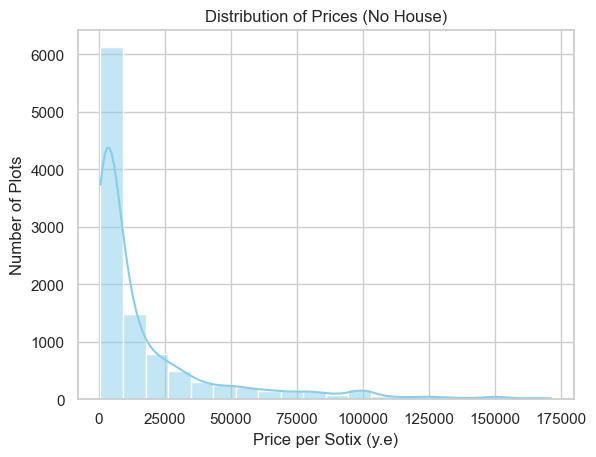

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # nicer background
sns.histplot(df_no_land['price_per_sotix(y.e)'], bins=20, kde=True, color='skyblue')
plt.xlabel("Price per Sotix (y.e)")
plt.ylabel("Number of Plots")
plt.title("Distribution of Prices (No House)")
plt.show()


In [46]:
pd.set_option('display.max_columns',None)

0         4.0
1         2.5
2         4.0
3         7.0
4         8.0
         ... 
16763     6.0
16764    11.0
16765     2.0
16766     6.0
16767     8.0
Name: extracted_land_area, Length: 16768, dtype: float64

In [ ]:
df_no_land[df_no_land['price_per_sotix(y.e)']<10000]

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,promotion_premium_ad_page,time,price_usd,price_currency,price_arranged,price_budget,price_negotiable,price_uzs,price_converted_currency,land_area,purpose,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e),has_house
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,0,2025-02-17,21000.0,UYE,1,0,1,2.718807e+08,UZS,4 соток,Другое,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5250.000000,5250.00,0
2,48788994,Зудлик билан 2 ёки 4 сотих ер учаска сотилади...,0,real_estate,Ташкентская область,Ташкент,Юнусабадский район,1,0,1,0,2024-04-30,22000.0,UYE,0,0,1,2.764168e+08,UZS,24 соток,Земля под сад/огород,"В городе, На закрытой территории, В пригороде","Электричество, Телефон, Канализация, Газ, Вода...",Нет,Делимый,4.0,55.000000,55.00,5500.000000,5500.00,0
3,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,1,2024-12-16,22000.0,UYE,1,0,1,2.821104e+08,UZS,7 соток,Земля под строительство,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3142.857143,3142.86,0
4,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2024-12-02,44999.0,UYE,1,0,1,5.801046e+08,UZS,6 соток,Земля под строительство,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5624.875000,5624.88,0
6,54283143,Продаётся земельный участок с кадастром \nКибр...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2025-02-03,27500.0,UYE,0,0,1,3.616278e+08,UZS,8 соток,Земля под строительство,В пригороде,"Электричество, Вода, Газ, Канализация, Интернет",Нет,NaN,8.0,34.375000,34.38,3437.500000,3437.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16760,50621707,Уч ховузда Ер урин 540 кв кумилган дакументдан...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2025-05-19,3000.0,UYE,1,0,1,3.894600e+07,UZS,540 соток,Земля с/х назначения,В сельской местности,NaN,Нет,NaN,5.4,5.555556,5.56,555.555556,555.56,0
16762,45283326,"Гурлан тумани, Катли худудида ер участкаси сот...",0,real_estate,Хорезмская область,Гурлен,0.0,0,0,0,0,2025-06-22,5000.0,UYE,1,0,1,6.283000e+07,UZS,4 соток,Земля под строительство,В сельской местности,NaN,Нет,NaN,4.0,12.500000,12.50,1250.000000,1250.00,0
16764,53101064,Урганч шахар санотчилар кучасида 1100кв цемент...,0,real_estate,Хорезмская область,Ургенч,0.0,1,0,1,0,2024-07-22,85000.0,UYE,0,0,1,1.070116e+09,UZS,1 100 соток,Другое,В городе,"Вода, Электричество, Газ",Нет,Неделимый,11.0,77.272727,77.27,7727.272727,7727.27,0
16765,54688508,Гулистон махалласи Дурдона кучаси жасмин магаз...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2024-06-24,5000.0,UYE,1,0,1,6.306400e+07,UZS,200 соток,Земля под строительство,В городе,NaN,Да,NaN,2.0,25.000000,25.00,2500.000000,2500.00,0


In [75]:
def outlier_remover(df,price_col,location_col):
    df_list=[]
    distinct_names = df[location_col].unique().tolist()
    for dist_name in distinct_names:
        temp = df[df[location_col]==dist_name]
        q1 = temp[price_col].quantile(0.25)
        q2 = temp[price_col].quantile(0.75)
        iqr=q2-q1

        lower_bound = q1-iqr*1.5
        upper_bound = q2+iqr*1.5
        temp_clean = temp[(temp[price_col]>lower_bound)&(temp[price_col]<upper_bound)]
        df_list.append(temp_clean)
    return pd.concat(df_list).reset_index(drop=True)

df_clean = outlier_remover(df, price_col='price_per_sotix(y.e)', location_col='location_district_name')


In [77]:
df

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,promotion_premium_ad_page,time,price_usd,price_currency,price_arranged,price_budget,price_negotiable,price_uzs,price_converted_currency,land_area,purpose,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e),has_house
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,0,2025-02-17,21000.0,UYE,1,0,1,2.718807e+08,UZS,4 соток,Другое,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5.250000e+03,5250.00,0
1,51622740,"ПРОДАЖА УЧАСТКА \nРайон: Яккасарайский,\n Ра...",1,real_estate,Ташкентская область,Ташкент,Яккасарайский район,0,0,0,1,2024-05-14,260000.0,UYE,1,0,1,3.304886e+09,UZS,2.50 соток,Земля под строительство,"В городе, Вдоль трассы","Электричество, Канализация, Газ, Вода, Отопление",Нет,Неделимый,2.5,1040.000000,1040.00,1.040000e+05,104000.00,0
2,48788994,Зудлик билан 2 ёки 4 сотих ер учаска сотилади...,0,real_estate,Ташкентская область,Ташкент,Юнусабадский район,1,0,1,0,2024-04-30,22000.0,UYE,0,0,1,2.764168e+08,UZS,24 соток,Земля под сад/огород,"В городе, На закрытой территории, В пригороде","Электричество, Телефон, Канализация, Газ, Вода...",Нет,Делимый,4.0,55.000000,55.00,5.500000e+03,5500.00,0
3,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,1,2024-12-16,22000.0,UYE,1,0,1,2.821104e+08,UZS,7 соток,Земля под строительство,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3.142857e+03,3142.86,0
4,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2024-12-02,44999.0,UYE,1,0,1,5.801046e+08,UZS,6 соток,Земля под строительство,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5.624875e+03,5624.88,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16763,56090518,Urganch tumani gʻallab mahallasi hayvat qishlo...,0,real_estate,Хорезмская область,Караул,0.0,0,0,0,0,2024-10-21,30000000.0,UZS,0,0,1,NaN,NaN,600 соток,Земля под строительство,В сельской местности,"Электричество, Телефон, Канализация, Вода, Инт...",Нет,Неделимый,6.0,50000.000000,50000.00,5.000000e+06,5000000.00,0
16764,53101064,Урганч шахар санотчилар кучасида 1100кв цемент...,0,real_estate,Хорезмская область,Ургенч,0.0,1,0,1,0,2024-07-22,85000.0,UYE,0,0,1,1.070116e+09,UZS,1 100 соток,Другое,В городе,"Вода, Электричество, Газ",Нет,Неделимый,11.0,77.272727,77.27,7.727273e+03,7727.27,0
16765,54688508,Гулистон махалласи Дурдона кучаси жасмин магаз...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2024-06-24,5000.0,UYE,1,0,1,6.306400e+07,UZS,200 соток,Земля под строительство,В городе,NaN,Да,NaN,2.0,25.000000,25.00,2.500000e+03,2500.00,0
16766,52119884,Срочно сотилоди бохосини\n галиштирип бараман ...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2024-09-16,120000000.0,UZS,1,0,1,NaN,NaN,6 соток,Земля с/х назначения,На закрытой территории,"Электричество, Вода",Нет,NaN,6.0,200000.000000,200000.00,2.000000e+07,20000000.00,0


In [78]:
df['location_district_name'].value_counts()

location_district_name
0                          8006
0.0                        3987
Мирзо-Улугбекский район     989
Юнусабадский район          882
Сергелийский район          739
Бектемирский район          490
Яшнабадский район           433
Яккасарайский район         366
Алмазарский район           298
Шайхантахурский район       203
Мирабадский район           168
Чиланзарский район          114
Учтепинский район            91
Name: count, dtype: int64

In [79]:
df['location_city_name'].value_counts()

location_city_name
Ташкент      4773
Кибрай        776
Джизак        424
Гулистан      418
Самарканд     413
             ... 
Муглан          1
Мубарек         1
Караузяк        1
Гульбахор       1
Туркестан       1
Name: count, Length: 203, dtype: int64

In [80]:
location_district_name ni location city name orqali topish

SyntaxError: invalid syntax (1535827664.py, line 1)

In [81]:
df_clean

,id,description,business,category_type,location_region_name,location_city_name,location_district_name,promotion_highlighted,promotion_urgent,promotion_top_ad,promotion_premium_ad_page,time,price_usd,price_currency,price_arranged,price_budget,price_negotiable,price_uzs,price_converted_currency,land_area,purpose,location,communications,comission,type_of_plot,extracted_land_area,price_per_sqm,price_per_sqm(y.e),price_per_sotix,price_per_sotix(y.e),has_house
0,52891158,Ассалому алейкум Назарбекда\n тукимачи маххала...,0,real_estate,Ташкентская область,Назарбек,0,0,0,0,0,2025-02-17,21000.0,UYE,1,0,1,2.718807e+08,UZS,4 соток,Другое,В пригороде,"Электричество, Газ, Вода, Интернет",Да,NaN,4.0,52.500000,52.50,5.250000e+03,5250.00,0
1,56466143,Продаётся земельный участок под строительство...,1,real_estate,Ташкентская область,Кибрай,0,0,0,0,1,2024-12-16,22000.0,UYE,1,0,1,2.821104e+08,UZS,7 соток,Земля под строительство,В городе,"Электричество, Вода, Газ, Канализация",Нет,Неделимый,7.0,31.428571,31.43,3.142857e+03,3142.86,0
2,55098422,Қибрай тумани Ёшлик маҳалласида жуда зўр жойда...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2024-12-02,44999.0,UYE,1,0,1,5.801046e+08,UZS,6 соток,Земля под строительство,"Вдоль трассы, Возле водоема, реки, В дачном ма...","Электричество, Вода, Газ",Нет,Делимый,8.0,56.248750,56.25,5.624875e+03,5624.88,0
3,54283143,Продаётся земельный участок с кадастром \nКибр...,0,real_estate,Ташкентская область,Кибрай,0,0,0,0,0,2025-02-03,27500.0,UYE,0,0,1,3.616278e+08,UZS,8 соток,Земля под строительство,В пригороде,"Электричество, Вода, Газ, Канализация, Интернет",Нет,NaN,8.0,34.375000,34.38,3.437500e+03,3437.50,0
4,55776194,Продается база с земельным участок \nПаркентск...,1,real_estate,Ташкентская область,Паркент,0,0,0,0,1,2024-11-25,650000.0,UYE,0,0,1,8.290490e+09,UZS,150 соток,Земля под строительство,"В городе, В пригороде",NaN,Нет,Неделимый,150.0,43.333333,43.33,4.333333e+03,4333.33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13621,45283326,"Гурлан тумани, Катли худудида ер участкаси сот...",0,real_estate,Хорезмская область,Гурлен,0.0,0,0,0,0,2025-06-22,5000.0,UYE,1,0,1,6.283000e+07,UZS,4 соток,Земля под строительство,В сельской местности,NaN,Нет,NaN,4.0,12.500000,12.50,1.250000e+03,1250.00,0
13622,56090518,Urganch tumani gʻallab mahallasi hayvat qishlo...,0,real_estate,Хорезмская область,Караул,0.0,0,0,0,0,2024-10-21,30000000.0,UZS,0,0,1,NaN,NaN,600 соток,Земля под строительство,В сельской местности,"Электричество, Телефон, Канализация, Вода, Инт...",Нет,Неделимый,6.0,50000.000000,50000.00,5.000000e+06,5000000.00,0
13623,53101064,Урганч шахар санотчилар кучасида 1100кв цемент...,0,real_estate,Хорезмская область,Ургенч,0.0,1,0,1,0,2024-07-22,85000.0,UYE,0,0,1,1.070116e+09,UZS,1 100 соток,Другое,В городе,"Вода, Электричество, Газ",Нет,Неделимый,11.0,77.272727,77.27,7.727273e+03,7727.27,0
13624,54688508,Гулистон махалласи Дурдона кучаси жасмин магаз...,0,real_estate,Хорезмская область,Хива,0.0,0,0,0,0,2024-06-24,5000.0,UYE,1,0,1,6.306400e+07,UZS,200 соток,Земля под строительство,В городе,NaN,Да,NaN,2.0,25.000000,25.00,2.500000e+03,2500.00,0


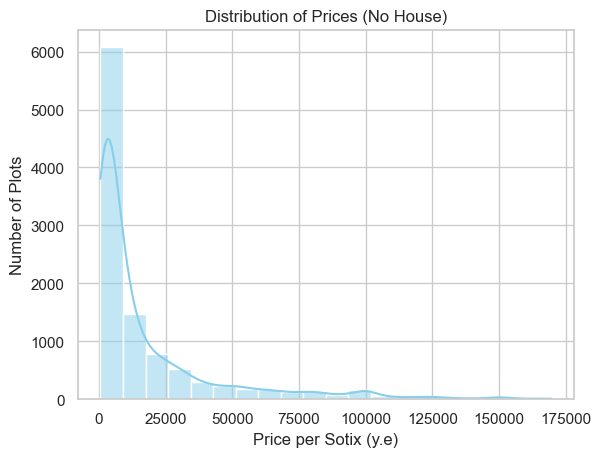

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # nicer background
sns.histplot(df_clean['price_per_sotix(y.e)'], bins=20, kde=True, color='skyblue')
plt.xlabel("Price per Sotix (y.e)")
plt.ylabel("Number of Plots")
plt.title("Distribution of Prices (No House)")
plt.show()


In [86]:
iqr1=df['price_per_sotix(y.e)'].quantile(0.25)
iqr2=df['price_per_sotix(y.e)'].quantile(0.75)

iqr = iqr2-iqr1

low_bound = iqr1-1.5*iqr

upper_bound = iqr2+1.5*iqr

df_clean = df_clean[(df_clean['price_per_sotix(y.e)']>500)&(df_clean['price_per_sotix(y.e)']<170000)&(df_clean['has_house']==0)]

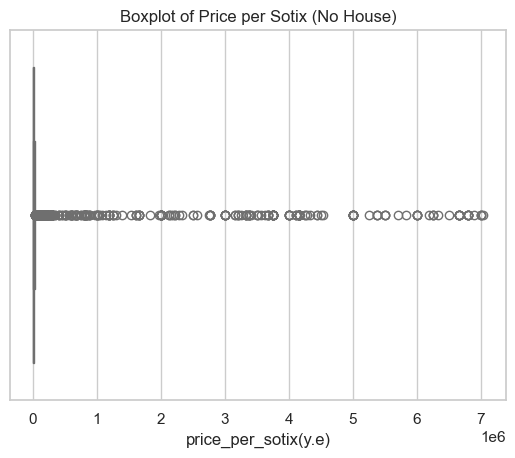

In [85]:
sns.boxplot(x=df_clean['price_per_sotix(y.e)'], color='skyblue')
plt.title("Boxplot of Price per Sotix (No House)")
plt.show()